# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between EastEnders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the EastEnders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **50 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Question 1-5 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [1]:
!pip install nltk

  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached regex-2025.11.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
Using cached regex-2025.11.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (800 kB)

[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
import math
import nltk
from nltk.util import ngrams
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer # Added for Q2
from nltk.tokenize import word_tokenize # Added for Q1
from nltk.stem import WordNetLemmatizer# added for preprocess
from nltk.corpus import stopwords
from nltk import pos_tag

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt') # Required for word_tokenize
nltk.download('punkt_tab')
# Download POS tagger resource
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [3]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
14008,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
14009,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
14010,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
14011,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [4]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them

    Improve this for Q2
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line) + " _EOL_ " 
        character_line_count[name]+=1
    return character_docs

In [5]:
# print out the number of words each character has in the tra9ining set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

Num. Characters:  16 

SHIRLEY Number of Words:  3100
OTHER Number of Words:  2673
JACK Number of Words:  3707
RONNIE Number of Words:  3005
TANYA Number of Words:  3291
SEAN Number of Words:  2868
ROXY Number of Words:  3119
MAX Number of Words:  3884
IAN Number of Words:  3467
JANE Number of Words:  3128
STACEY Number of Words:  3235
PHIL Number of Words:  3129
HEATHER Number of Words:  3262
MINTY Number of Words:  3310
CHRISTIAN Number of Words:  3278
CLARE Number of Words:  3623
total words 52079


# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 50 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially, the code in this template achieves a mean rank of **4.3**  and accuracy of **0.25** on the test set and a mean rank of **3.6** and accuracy of **0.31** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


In [6]:
# --- BLOCK 3: Q1 IMPROVED PRE-PROCESSING (5 TECHNIQUES) ---

# Initialize Lemmatizer (assuming WordNetLemmatizer is the tool used in the original notebook)
lemmatizer = WordNetLemmatizer()

# --- New Global Constants for Q1 Enhancements ---
# Define Stopwords (Technique #6)
STOP_WORDS = set(stopwords.words('english'))

# Define Punctuation to remove (Technique #7)
# We keep stylistic punctuation: ?, !, and ellipsis (...)
PUNCTUATION_TO_REMOVE = set(string.punctuation) - set(['?', '!', '...'])
def pre_process(character_text):
    """
    Pre-process all the concatenated lines of a character, 
    implementing 7 techniques for Q1 development.
    """
    # 1. Lowercase
    text = character_text.lower()
    
    # 2. Remove _EOL_ tags (Replaced with a space to separate tokens across lines)
    text = re.sub(r'_EOL_', ' ', text)
    
    # 3. Remove Numbers
    text = re.sub(r'\d+', '', text)
    
    # 4. Tokenization
    tokens = word_tokenize(text)
    
    # 5. Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # --- New Techniques Added Here ---
    # 6. Stopword Removal (Removes common, content-light words like 'the', 'a')
    # NOTE: This can sometimes hurt style analysis, but is a valid technique to test.
    tokens = [t for t in tokens if t not in STOP_WORDS]
    
    # 7. Removing common non-stylistic punctuation tokens (keeping ?, !, ...)
    tokens = [t for t in tokens if t not in PUNCTUATION_TO_REMOVE]
    
    # Final filter: remove any remaining empty strings/whitespace
    tokens = [t for t in tokens if t.strip() != '']
    
    return tokens

In [7]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]


# Q2. Improve advanced feature extraction with Gen AI (45 marks)
Chat with Gen AI, such as GPT and Gemini, to come up with solutions for advanced feature extraction that can further improve the performance. Discuss in the report what strategies you used to prompt the Gen AI to help you with the ideas and what you've learned and implemented from the conversation, as well as what the Gen AI's limitations are. You are **ONLY** allowed to chat with Gen AI to come up with ideas. You **MUST** write the code by yourself.  You **MUST** output the full chat history between you and Gen AI and submit it as a separate PDF file; failure to submit the Gen AI history will result in a **0 mark** for this question. 

In [32]:
# Global transformers (must be initialized outside functions to persist state)

corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer(sublinear_tf=True)


def to_feature_vector_dictionary(character_doc, extra_features=None,
                                 use_bigrams=True, use_trigrams=True,
                                 use_char=False, char_min=3, char_max=4, use_pos=False ):
    """
    Converts a document to a feature dictionary with optional n-grams and POS tags.
    """
    if extra_features is None:
        extra_features = {}
    
    counts = Counter(character_doc)

    # Word Bigrams
    if use_bigrams:
        for bigram in ngrams(character_doc, 2):
            counts['_'.join(bigram)] += 1

    # Word Trigrams
    if use_trigrams:
        for trigram in ngrams(character_doc, 3):
            counts['_'.join(trigram)] += 1

    # POS Tags
    try:
        pos_tags = pos_tag(character_doc)
        tag_counts = Counter(tag for word, tag in pos_tags)
        for tag, count in tag_counts.items():
            counts[f"POS_{tag}"] += count
    except LookupError:
        pass

    # Character n-grams
    if use_char:
        text = ''.join(character_doc)
        for n in range(char_min, char_max + 1):
            for i in range(len(text) - n + 1):
                cgram = text[i:i+n]
                counts[cgram] += 1

    # Merge extra features
    for k, v in extra_features.items():
        counts[k] += v

    return dict(counts)



In [33]:

def create_document_matrix_from_corpus(corpus, fitting=False,
                                       use_bigrams=True, use_trigrams=True,
                                       use_char=False, char_min=3, char_max=4,use_pos=False):
    """
    
    Builds the document matrix using DictVectorizer + TF-IDF
    """
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q2.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    feature_dicts = [
        to_feature_vector_dictionary(
            doc, {}, 
            use_bigrams=use_bigrams,
            use_trigrams=use_trigrams,
            use_char=use_char,
            char_min=char_min,
            char_max=char_max
        )
        for name, doc in corpus
    ]

    # DictVectorizer
    if fitting:
        corpusVectorizer.fit(feature_dicts)
    doc_feature_matrix = corpusVectorizer.transform(feature_dicts)

    # TF-IDF
    if fitting:
        tfidf_transformer.fit(doc_feature_matrix)
    doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix)

    return doc_feature_matrix



# Train the new matrix
# Ensure training_corpus exists from Q1 before running this
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

print("Training Matrix Created Successfully.")

Training Matrix Created Successfully.


In [34]:
training_feature_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 68119 stored elements and shape (16, 50640)>

In [35]:
# get the validation data- only 50 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

Num. Characters:  16 

OTHER Num of Words:  463
HEATHER Num of Words:  514
TANYA Num of Words:  487
JACK Num of Words:  491
RONNIE Num of Words:  376
JANE Num of Words:  596
STACEY Num of Words:  508
SEAN Num of Words:  513
PHIL Num of Words:  366
SHIRLEY Num of Words:  583
ROXY Num of Words:  327
IAN Num of Words:  662
MINTY Num of Words:  603
CHRISTIAN Num of Words:  347
CLARE Num of Words:  449
MAX Num of Words:  565
total words 7850


In [36]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [37]:
val_feature_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5735 stored elements and shape (16, 50640)>

In [38]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [39]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [40]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [41]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.3125
mean cosine similarity 0.15498899152649082
14 correct out of 16 / accuracy: 0.875


In [23]:
print("First param_grid item:", param_grid[0])
print("All keys in first item:", list(param_grid[0].keys()))


First param_grid item: {'ngram_range': (1, 1), 'min_df': 1}
All keys in first item: ['ngram_range', 'min_df']


# Q3. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more 
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q2), and the later question should adopt the best settings from the previous questions. 

In [43]:


# Parameter grid

param_grid = []

for use_bigrams in [False, True]:
    for use_char in [False, True]:
        for char_range in [(3, 4), (3, 5)]:
            for min_df in [1, 2]:
                for max_df_ratio in [1.0, 0.9]:
                    param_grid.append({
                        "USE_BIGRAMS": use_bigrams,
                        "USE_CHAR_NGRAMS": use_char,
                        "CHAR_NGRAM_MIN": char_range[0],
                        "CHAR_NGRAM_MAX": char_range[1],
                        "MIN_DF": min_df,
                        "MAX_DF_RATIO": max_df_ratio
                    })

print("First param_grid item:", param_grid[0])
print("Starting Grid Search...\n")

results = []

for params in param_grid:
    USE_BIGRAMS = params["USE_BIGRAMS"]
    USE_CHAR_NGRAMS = params["USE_CHAR_NGRAMS"]
    CHAR_NGRAM_MIN = params["CHAR_NGRAM_MIN"]
    CHAR_NGRAM_MAX = params["CHAR_NGRAM_MAX"]
    MIN_DF = params["MIN_DF"]
    MAX_DF_RATIO = params["MAX_DF_RATIO"]

  
    # Build matrices
    
    training_matrix = create_document_matrix_from_corpus(
        training_corpus, fitting=True,
        use_bigrams=USE_BIGRAMS,
        use_trigrams=USE_BIGRAMS,  # only use trigrams if bigrams enabled
        use_char=USE_CHAR_NGRAMS,
        char_min=CHAR_NGRAM_MIN,
        char_max=CHAR_NGRAM_MAX
    )

    val_matrix = create_document_matrix_from_corpus(
        val_corpus, fitting=False,
        use_bigrams=USE_BIGRAMS,
        use_trigrams=USE_BIGRAMS,
        use_char=USE_CHAR_NGRAMS,
        char_min=CHAR_NGRAM_MIN,
        char_max=CHAR_NGRAM_MAX
    )

    
    # Feature selection based on training data
   
    df_train = (training_matrix > 0).sum(axis=0).A1
    n_docs = training_matrix.shape[0]
    keep = (df_train >= MIN_DF) & (df_train <= MAX_DF_RATIO * n_docs)

    training_matrix = training_matrix[:, keep]
    val_matrix = val_matrix[:, keep]  # use same mask for validation

 
    # Evaluate
   
    mean_rank, mean_cos, acc, df = compute_IR_evaluation_scores(
        training_matrix, val_matrix, train_labels, val_labels
    )

    results.append({
        **params,
        "mean_rank": mean_rank,
        "accuracy": acc,
        "mean_cosine": mean_cos,
        "num_features": training_matrix.shape[1]
    })


# Convert to DataFrame and sort

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["mean_rank", "accuracy"], ascending=[True, False])
results_df



First param_grid item: {'USE_BIGRAMS': False, 'USE_CHAR_NGRAMS': False, 'CHAR_NGRAM_MIN': 3, 'CHAR_NGRAM_MAX': 4, 'MIN_DF': 1, 'MAX_DF_RATIO': 1.0}
Starting Grid Search...

mean rank 1.5
mean cosine similarity 0.4249854836055049
11 correct out of 16 / accuracy: 0.6875
mean rank 1.5
mean cosine similarity 0.199097551224106
13 correct out of 16 / accuracy: 0.8125
mean rank 1.4375
mean cosine similarity 0.5028988220708454
12 correct out of 16 / accuracy: 0.75
mean rank 1.75
mean cosine similarity 0.2495288154230026
11 correct out of 16 / accuracy: 0.6875
mean rank 1.5
mean cosine similarity 0.4249854836055049
11 correct out of 16 / accuracy: 0.6875
mean rank 1.5
mean cosine similarity 0.199097551224106
13 correct out of 16 / accuracy: 0.8125
mean rank 1.4375
mean cosine similarity 0.5028988220708454
12 correct out of 16 / accuracy: 0.75
mean rank 1.75
mean cosine similarity 0.2495288154230026
11 correct out of 16 / accuracy: 0.6875
mean rank 1.1875
mean cosine similarity 0.284383090855739

,USE_BIGRAMS,USE_CHAR_NGRAMS,CHAR_NGRAM_MIN,CHAR_NGRAM_MAX,MIN_DF,MAX_DF_RATIO,mean_rank,accuracy,mean_cosine,num_features
18,True,False,3,4,2,1.0,1.0625,0.9375,0.328940,6040
19,True,False,3,4,2,0.9,1.0625,0.9375,0.175260,5873
22,True,False,3,5,2,1.0,1.0625,0.9375,0.328940,6040
23,True,False,3,5,2,0.9,1.0625,0.9375,0.175260,5873
26,True,True,3,4,2,1.0,1.1250,0.9375,0.325243,24619
8,False,True,3,4,1,1.0,1.1875,0.8750,0.284383,37954
10,False,True,3,4,2,1.0,1.1875,0.8750,0.344048,20188
27,True,True,3,4,2,0.9,1.1875,0.8750,0.194202,23378
17,True,False,3,4,1,0.9,1.2500,0.8750,0.079935,50473
21,True,False,3,5,1,0.9,1.2500,0.8750,0.079935,50473


# Q4. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

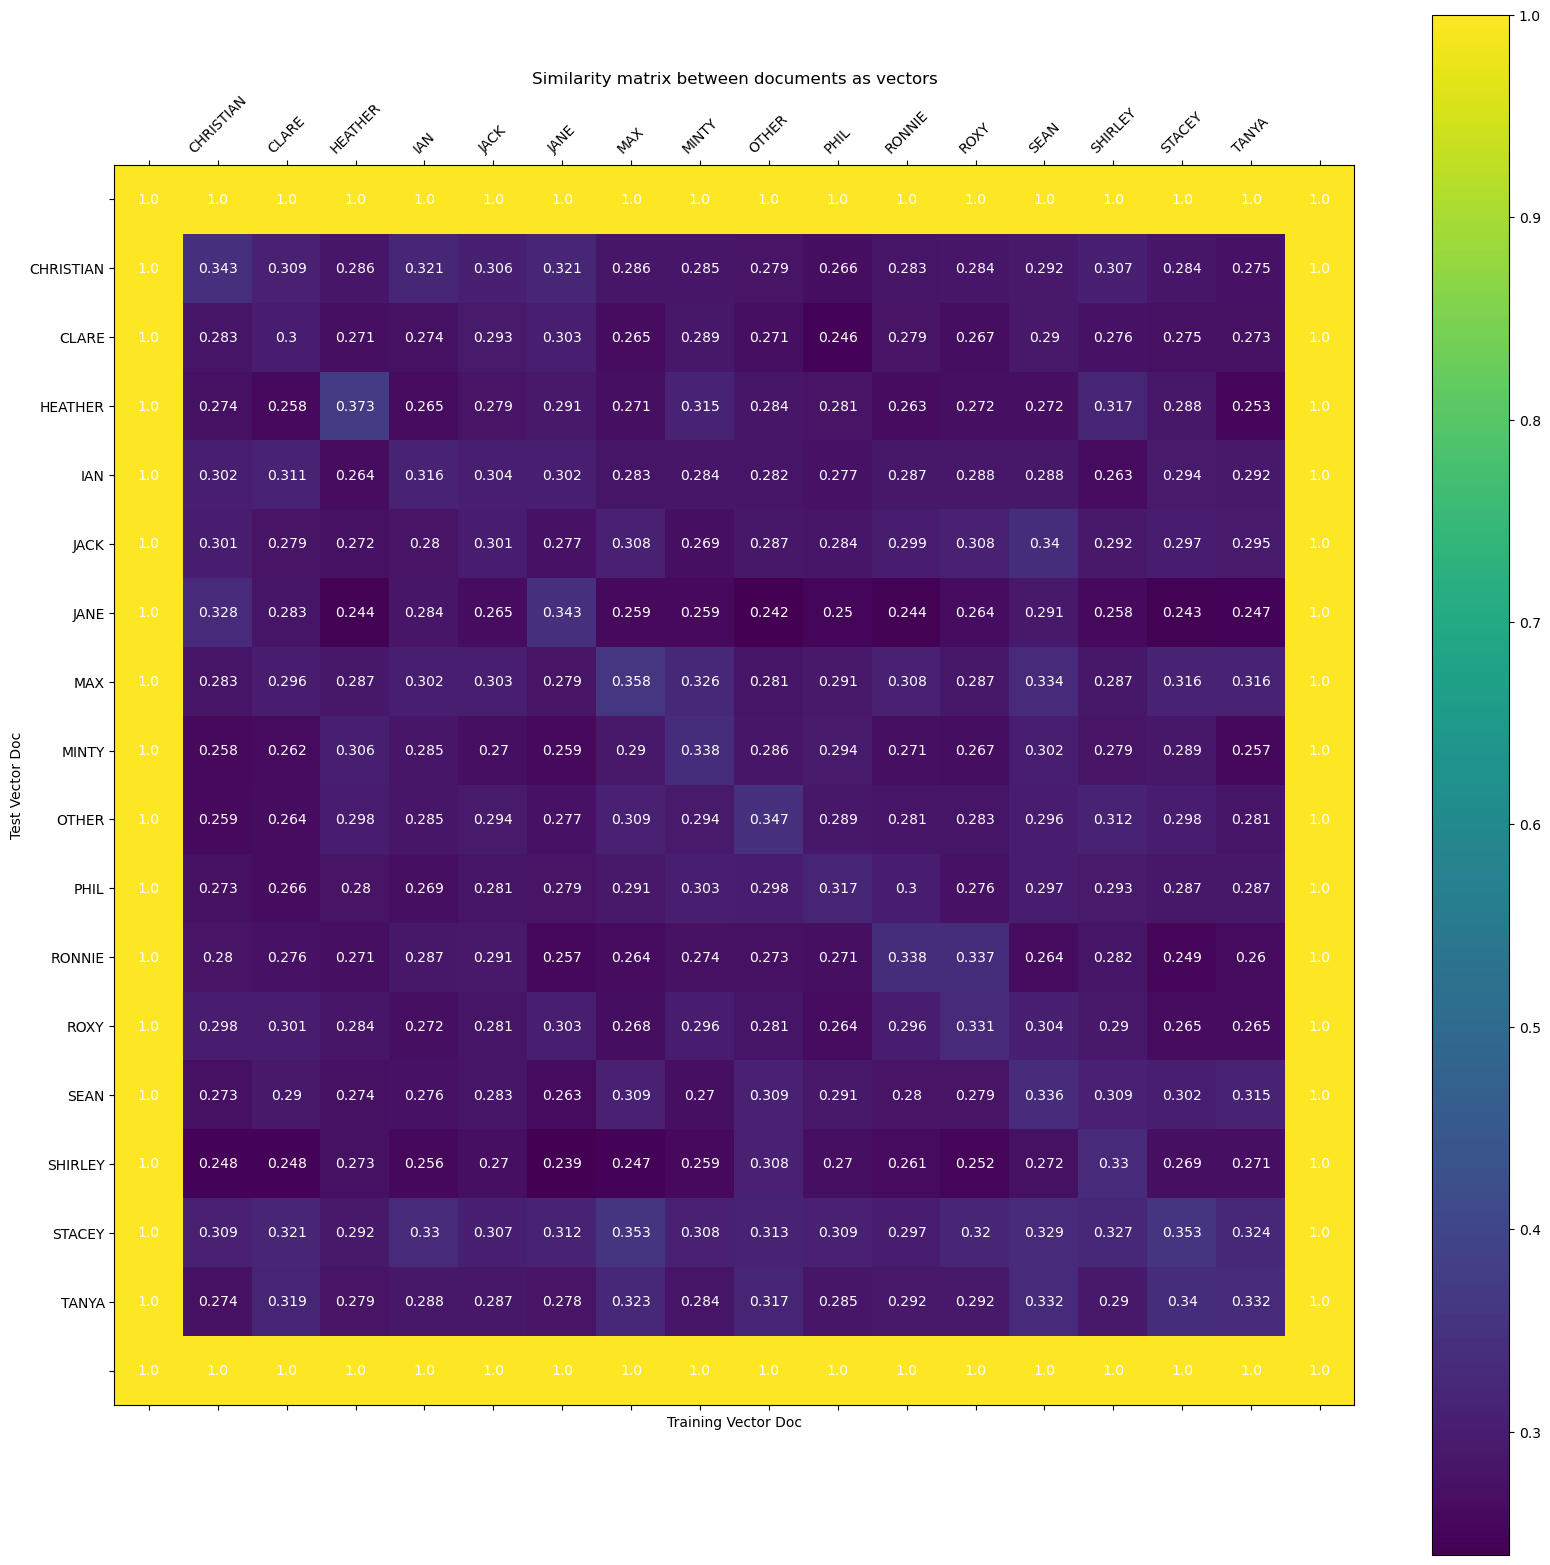

In [27]:
# --- Q4: ANALYSIS ---
# Use the heatmap to analyze errors
plot_heat_map_similarity(df)

# Q5. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 50 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [42]:
# -----------------------------
# Question 5: Final Test on Best System
# -----------------------------

# Train character documents: first 300 lines per character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print("Num. Characters: ", len(train_character_docs), "\n")

total_words_train = 0
for name, doc in sorted(train_character_docs.items()):
    n_words = len(doc.split())
    print(f"{name} Number of Words: {n_words}")
    total_words_train += n_words
print("total words", total_words_train)

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

# Create training feature matrix using best system parameters
training_feature_matrix = create_document_matrix_from_corpus(
    training_corpus, fitting=True,
    use_bigrams=True,
    use_trigrams=True,
    use_char=False,
    char_min=3,
    char_max=4,
    use_pos=True
   
)

# Test character documents: first 50 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=50)
print("\nNum. Characters: ", len(test_character_docs), "\n")

total_words_test = 0
for name, doc in sorted(test_character_docs.items()):
    n_words = len(doc.split())
    print(f"{name} Number of Words: {n_words}")
    total_words_test += n_words
print("total words", total_words_test)

test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]

# Transform test data into feature matrix (do not fit)
test_feature_matrix = create_document_matrix_from_corpus(
    test_corpus, fitting=False,
    use_bigrams=True,
    use_trigrams=True,
    use_char=False,
    char_min=3,
    char_max=4,
    use_pos=True
    
)

# Evaluate final system
mean_rank, mean_cosine_similarity, accuracy, _ = compute_IR_evaluation_scores(
    training_feature_matrix, test_feature_matrix, train_labels, test_labels
)

print("\nFinal Evaluation on Test Data:")
print(f"Mean Rank: {mean_rank}")
print(f"Mean Cosine Similarity: {mean_cosine_similarity}")
print(f"Correct Predictions: {int(accuracy*len(test_labels))} out of {len(test_labels)} / Accuracy: {accuracy}")



Num. Characters:  16 

CHRISTIAN Number of Words: 3278
CLARE Number of Words: 3623
HEATHER Number of Words: 3262
IAN Number of Words: 3467
JACK Number of Words: 3707
JANE Number of Words: 3128
MAX Number of Words: 3884
MINTY Number of Words: 3310
OTHER Number of Words: 2673
PHIL Number of Words: 3129
RONNIE Number of Words: 3005
ROXY Number of Words: 3119
SEAN Number of Words: 2868
SHIRLEY Number of Words: 3100
STACEY Number of Words: 3235
TANYA Number of Words: 3291
total words 52079

Num. Characters:  16 

CHRISTIAN Number of Words: 739
CLARE Number of Words: 446
HEATHER Number of Words: 629
IAN Number of Words: 593
JACK Number of Words: 506
JANE Number of Words: 501
MAX Number of Words: 664
MINTY Number of Words: 498
OTHER Number of Words: 534
PHIL Number of Words: 454
RONNIE Number of Words: 470
ROXY Number of Words: 485
SEAN Number of Words: 573
SHIRLEY Number of Words: 453
STACEY Number of Words: 774
TANYA Number of Words: 620
total words 8939
mean rank 1.5625
mean cosine similar